This notebook will walk through some of the analysis that we did using Pythia12B on the MATH dataset.

In [85]:
import sys
import os
import src.analyze as analyze
import src.stats_utils as stats_utils
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy
import sklearn
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

In [75]:
import importlib

importlib.reload(stats_utils)

<module 'src.stats_utils' from '/Users/jkazdan/Documents/Research/monkeys/KoyejoLab-Origin-Power-Laws-Scaling-Inference-Compute/src/stats_utils.py'>

In [2]:
# get data for the number of math problems solved
data = analyze.create_or_load_large_language_monkeys_pythia_math_pass_at_k_df()

# this tells us whether each attempt was a success or failure -- I don't think it adds any
# value given that the attempts were independent
individual_data = (
    analyze.create_or_load_large_language_monkeys_pythia_math_individual_outcomes_df()
)

Loaded /Users/jkazdan/Documents/Research/monkeys/KoyejoLab-Origin-Power-Laws-Scaling-Inference-Compute/data/processed_data/large_language_monkeys_pythia_math_pass_at_k.parquet with shape:  (90496, 7)
Loaded /Users/jkazdan/Documents/Research/monkeys/KoyejoLab-Origin-Power-Laws-Scaling-Inference-Compute/data/processed_data/large_language_monkeys_pythia_math_individual_outcomes.parquet with shape:  (8960000, 5)


In [3]:
# label the number of total samples and compute the number of correct attempts for each problem
data["Num. Samples Total"] = 10000
data["Num. Samples Correct"] = data["Score"] * data["Num. Samples Total"]
data.head()

,Score,Scaling Parameter,Problem Idx,Model,Benchmark,Log Score,Neg Log Score,Num. Samples Total,Num. Samples Correct
0,0.0122,1,0,Pythia 12B,MATH,-4.406319,4.406319,10000,122.0
1,0.0032,1,1,Pythia 12B,MATH,-5.744604,5.744604,10000,32.0
2,0.0167,1,2,Pythia 12B,MATH,-4.092347,4.092347,10000,167.0
3,0.0001,1,3,Pythia 12B,MATH,-9.210340,9.210340,10000,1.0
4,0.2227,1,4,Pythia 12B,MATH,-1.501930,1.501930,10000,2227.0


In [4]:
# let's start by looking at the math dataset
math_data = data[data["Benchmark"] == "MATH"]

In [5]:
# let's look at Pythia12B only
pythia12_math = math_data[math_data["Model"] == "Pythia 6.9B"]

A brief overview of the fitting methods:
- The two parameter beta distribution is fit on estimated probabilities using scipy
- The three parameter beta distribution is again fit with scipy using an estimated scale parameter given by highest_observed_success_rate*(num_samples+1)/num_samples.  Although this choice of scale parameter would cause make the likelihood under this model of observing higher pass@1 on a new question 0.  Therefore, this model is bad when trying to extrapolate to a test set of witheld problems, but good when estimating scaling laws (because if we don't observe a single success for a given question in 10,000 samples, it's unlikely that the true pass@1 is higher than 22.7%)  This is more of a problem if we specifically care about estimating the distribution rather than the power law, or if we have fewer samples.
- The discretized beta distribution: We bin the success probabilities before fitting the beta distribution directly on the fitted probabilities.  The binning occurs on a log scale to prioritize fitting the left tail of the distribution accurately.  This fit is designed for estimating power laws in the low-sample regime.  

In [6]:
beta_2_params = (
    analyze.fit_beta_binomial_two_parameters_to_num_samples_and_num_successes(
        pythia12_math
    )
)
beta_3_params = (
    analyze.fit_beta_binomial_three_parameters_to_num_samples_and_num_successes(
        pythia12_math
    )
)
beta_3_discretized_params = (
    analyze.fit_discretized_beta_three_parameters_to_num_samples_and_num_successes(
        pythia12_math
    )
)

/Users/jkazdan/miniforge3/envs/finance/lib/python3.12/site-packages/scipy/optimize/_numdiff.py:590: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0


the scale is 1.0


In [7]:
# result of fitting a 2-parameter beta
beta_2_params

alpha                 0.5
beta                  3.5
loc                   0.0
scale                 1.0
neg_log_likelihood    NaN
aic                   NaN
bic                   NaN
Power Law Exponent    0.5
dtype: float64

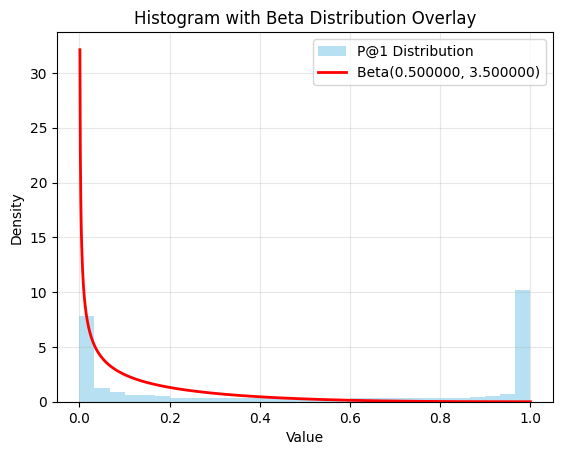

In [8]:
stats_utils.plot_histo_and_beta(pythia12_math["Score"], beta_2_params)

Both of the 3-parameter beta fits work comparably when we are fitting large amounts of data.

In [9]:
print("Beta 3 params")
print(beta_3_params)
print("Beta 3 params discretized")
print(beta_3_discretized_params)

Beta 3 params
alpha                 0.122504
beta                  0.102996
loc                        0.0
scale                      1.0
neg_log_likelihood    5.455029
maxiter                   5000
success                Success
dtype: object
Beta 3 params discretized
alpha                  0.135767
beta                   0.123904
loc                         0.0
scale                       1.0
neg_log_likelihood    55.769272
success                 Success
dtype: object


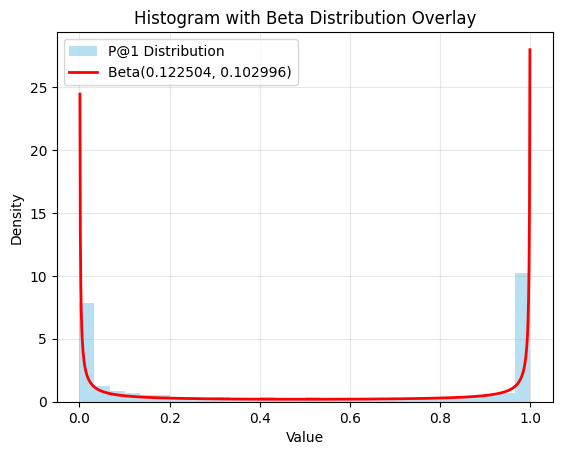

In [10]:
stats_utils.plot_histo_and_beta(pythia12_math["Score"], beta_3_params)

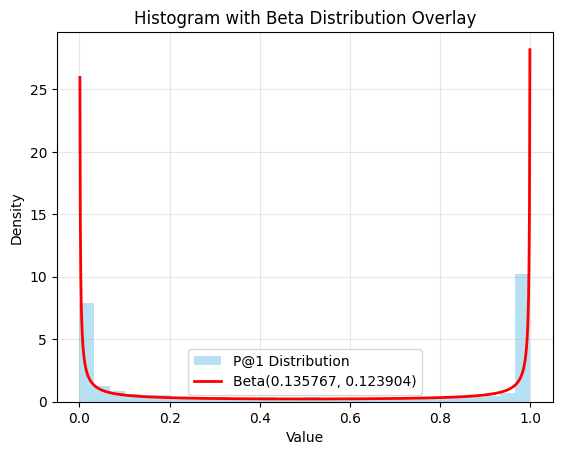

In [11]:
stats_utils.plot_histo_and_beta(pythia12_math["Score"], beta_3_discretized_params)

Now that we have observed the high-samples regime, let's look at what happens when there is only a small number of samples for each problem -- we will subsample only 20 attempts per problem and refit the distributions. Note that in order to fit the scaling law, beta is irrelevant.  Therefore, we are interested in understanding how close we can get to alpha.   

In [12]:
data.head()

,Score,Scaling Parameter,Problem Idx,Model,Benchmark,Log Score,Neg Log Score,Num. Samples Total,Num. Samples Correct
0,0.0122,1,0,Pythia 12B,MATH,-4.406319,4.406319,10000,122.0
1,0.0032,1,1,Pythia 12B,MATH,-5.744604,5.744604,10000,32.0
2,0.0167,1,2,Pythia 12B,MATH,-4.092347,4.092347,10000,167.0
3,0.0001,1,3,Pythia 12B,MATH,-9.210340,9.210340,10000,1.0
4,0.2227,1,4,Pythia 12B,MATH,-1.501930,1.501930,10000,2227.0


In [13]:
smaller_data = data[[]]
samples = 20
probs = pythia12_math["Score"]
smaller_data = {
    "Num. Samples Correct": np.random.binomial(n=samples, p=probs),
    "Num. Samples Total": np.ones(len(pythia12_math)) * 20,
}
smaller_pythia12_math = pd.DataFrame(smaller_data)
smaller_pythia12_math["Score"] = (
    smaller_pythia12_math["Num. Samples Correct"]
    / smaller_pythia12_math["Num. Samples Total"]
)

In [14]:
smaller_pythia12_math.head()

,Num. Samples Correct,Num. Samples Total,Score
0,0,20.0,0.0
1,0,20.0,0.0
2,0,20.0,0.0
3,0,20.0,0.0
4,6,20.0,0.3


We refit the data using the same three methods as before.  We will take the expectation of the resulting beta binomials and see which one estimates the largest pass@k for the full data.  

In [15]:
smaller_beta_2_params = (
    analyze.fit_beta_binomial_two_parameters_to_num_samples_and_num_successes(
        smaller_pythia12_math
    )
)
smaller_beta_3_params = (
    analyze.fit_beta_binomial_three_parameters_to_num_samples_and_num_successes(
        smaller_pythia12_math
    )
)
smaller_beta_3_discretized_params = (
    analyze.fit_discretized_beta_three_parameters_to_num_samples_and_num_successes(
        smaller_pythia12_math
    )
)

the scale is 1.0


Let's now plot the beta fit along with the entire distribution.

alpha                  0.213963
beta                   0.067643
loc                    0.000000
scale                  1.000000
neg_log_likelihood     2.401134
aic                    8.802268
bic                   23.736570
Power Law Exponent     0.213963
dtype: float64


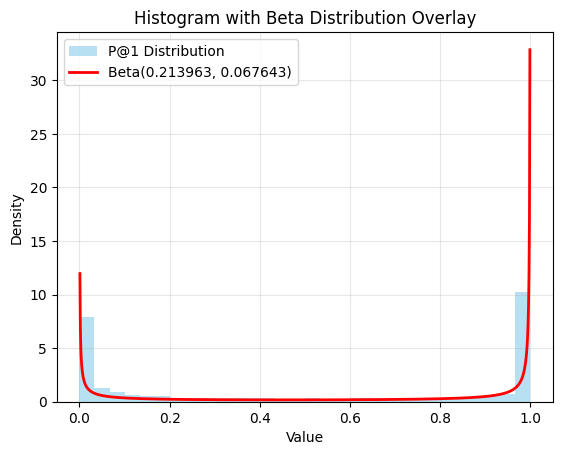

In [16]:
print(smaller_beta_2_params)
stats_utils.plot_histo_and_beta(pythia12_math["Score"], smaller_beta_2_params)

alpha                 0.168106
beta                  0.147358
loc                        0.0
scale                      1.0
neg_log_likelihood    2.224731
maxiter                   5000
success                Success
dtype: object


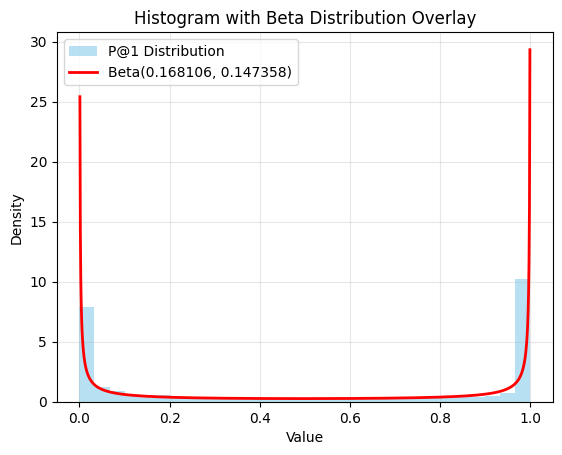

In [17]:
print(smaller_beta_3_params)
stats_utils.plot_histo_and_beta(pythia12_math["Score"], smaller_beta_3_params)

alpha                  0.084984
beta                    0.08588
loc                         0.0
scale                       1.0
neg_log_likelihood    46.094422
success                 Success
dtype: object


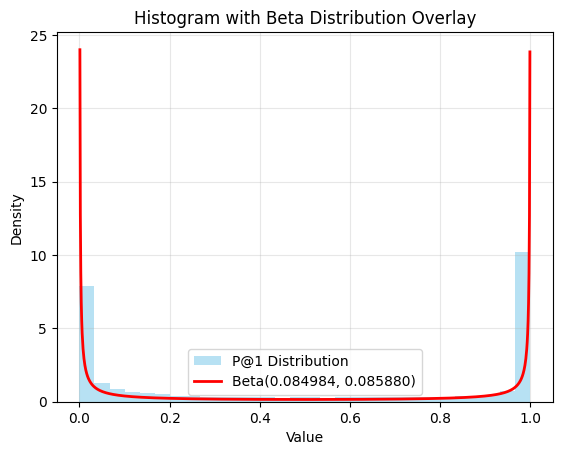

In [18]:
print(smaller_beta_3_discretized_params)
stats_utils.plot_histo_and_beta(
    pythia12_math["Score"], smaller_beta_3_discretized_params
)

Now let's measure how far off $\alpha$ is for each of these fits from the originals.

In [19]:
print(f'beta_2_params error: {beta_2_params['alpha']-smaller_beta_2_params['alpha']}')
print(f'beta_3_params error: {beta_3_params['alpha'] - smaller_beta_3_params['alpha']}')
print(f'beta_3_discretized_error: {beta_3_discretized_params['alpha'] - smaller_beta_3_discretized_params['alpha']}')

beta_2_params error: 0.2860370301622053
beta_3_params error: -0.045601683218879696
beta_3_discretized_error: 0.0507824691467863


In [20]:
# let's compute the true pass@k
p_at_k = 1 - (len(pythia12_math[pythia12_math["Num. Samples Correct"] == 0])) / len(
    pythia12_math
)
print(f"Measured pass@k success rate: {p_at_k}")

Measured pass@k success rate: 0.8359375


Let's also compute the predicted pass@k for each of the predicted beta-binomials.  Specifically, we want to compute:

$1-\int_0^1 {n\choose{0}}(1-p)^k dG(p)$ where $G(p)$ is the fitted beta distribution.

Let's estimate pass@k from both the subset of data and the full data for each method

In [21]:
smaller_beta_2_pass_at_10000 = 1 - np.exp(
    -1
    * analyze.compute_beta_binomial_three_parameters_distribution_neg_log_likelihood(
        params=(smaller_beta_2_params["alpha"], smaller_beta_2_params["beta"]),
        scale=1.0,
        num_samples=np.array([10000]),
        num_successes=np.array([0]),
    )
)
smaller_beta_2_pass_at_10000

0.96877054939415

In [22]:
beta_2_pass_at_10000 = 1 - np.exp(
    -1
    * analyze.compute_beta_binomial_three_parameters_distribution_neg_log_likelihood(
        params=(beta_2_params["alpha"], beta_2_params["beta"]),
        scale=1.0,
        num_samples=np.array([10000]),
        num_successes=np.array([0]),
    )
)
beta_2_pass_at_10000

0.9819488664002083

This is strange!  The data fit on the subset is a better estimator of the true pass@k than the data fit on the entire set

In [23]:
smaller_beta_3_pass_at_10000 = 1 - np.exp(
    -1
    * analyze.compute_beta_binomial_three_parameters_distribution_neg_log_likelihood(
        params=(smaller_beta_3_params["alpha"], smaller_beta_3_params["beta"]),
        scale=smaller_beta_3_params["scale"],
        num_samples=np.array([10000]),
        num_successes=np.array([0]),
    )
)
smaller_beta_3_pass_at_10000

0.9048001173349793

In [24]:
beta_3_pass_at_10000 = 1 - np.exp(
    -1
    * analyze.compute_beta_binomial_three_parameters_distribution_neg_log_likelihood(
        params=(beta_3_params["alpha"], beta_3_params["beta"]),
        scale=beta_3_params["scale"],
        num_samples=np.array([10000]),
        num_successes=np.array([0]),
    )
)
beta_3_pass_at_10000

0.8581710553002244

In [25]:
smaller_beta_3_discrete_pass_at_10000 = 1 - np.exp(
    -1
    * analyze.compute_beta_binomial_three_parameters_distribution_neg_log_likelihood(
        params=(
            smaller_beta_3_discretized_params["alpha"],
            smaller_beta_3_discretized_params["beta"],
        ),
        scale=smaller_beta_3_params["scale"],
        num_samples=np.array([10000]),
        num_successes=np.array([0]),
    )
)
smaller_beta_3_discrete_pass_at_10000

0.7776080696724945

In [26]:
beta_3_discrete_pass_at_10000 = 1 - np.exp(
    -1
    * analyze.compute_beta_binomial_three_parameters_distribution_neg_log_likelihood(
        params=(beta_3_discretized_params["alpha"], beta_3_discretized_params["beta"]),
        scale=beta_3_params["scale"],
        num_samples=np.array([10000]),
        num_successes=np.array([0]),
    )
)
beta_3_discrete_pass_at_10000

0.8688198046275155

Rylan claimed that the pass@k estimates for the discretized distribution were superior.  Based on this analysis, the standard beta binomial estimator seems to work better.  There are many more models and datasets that one could analyze, though.  Maybe this observation doesn't hold widely across models.  It does seem fairly spectacular that with just 10 samples per problem we are able to estimate pass@k using this method within 2%.  

In [27]:
smaller_pythia12_math

,Num. Samples Correct,Num. Samples Total,Score
0,0,20.0,0.0
1,0,20.0,0.0
2,0,20.0,0.0
3,0,20.0,0.0
4,6,20.0,0.3
...,...,...,...
12923,20,20.0,1.0
12924,0,20.0,0.0
12925,0,20.0,0.0
12926,0,20.0,0.0


Finally, let's look at the original estimator developed for fitting power laws.

In [28]:
# original estimator
ks = np.array([i for i in range(1, 21)])
pass_at_ks = analyze.compute_pass_at_k_from_num_samples_and_num_successes_df(
    smaller_pythia12_math, ks
)
pass_at_ks = pass_at_ks.groupby("Scaling Parameter")["Score"].mean()
model = LinearRegression(fit_intercept=True)
model.fit(np.log(ks).reshape(-1, 1), -np.log(pass_at_ks))
np.exp(-model.predict(np.log([10000]).reshape(-1, 1)))

array([1.47319818])

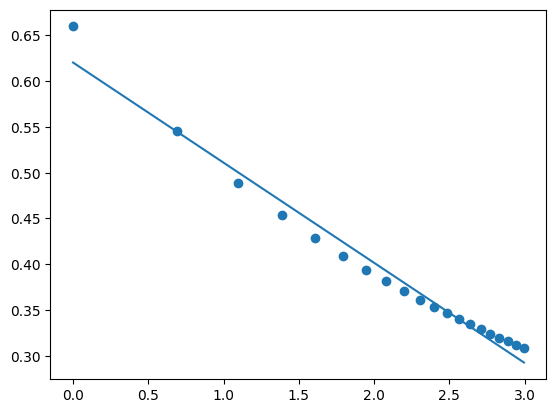

In [29]:
plt.scatter(np.log(ks), -np.log(pass_at_ks))
plt.plot(np.log(ks), model.predict(np.log(ks).reshape(-1, 1)))

In [30]:
model.intercept_

0.6204568434919138


Define $\eta_x = \mathbb{E}[n_x]$, or the expected number of samples observed $x$ times in the first $[-k, 0)$ trials (we write this as a continuous interval to be consistent with Efron, but really it is $\{-k, -k+1,...,-1\})$.

Under our model using Efron's notation, $$\eta_x = S\int_0^1 {k\choose{x}} p^x(1-p)^{k-x} dG(p)$$.
Let $t= n/k<1$, i.e. the number of new samples divided by the number of samples taken so far.  We also will need to assume that all of the probabilities are small in the sense that $(1-p_i)^n \approx (1-np_i)$ for all probabilities and $(1-p_i)^k \approx (1-p_i)^n$.  This is an obviously unrealistic assumption in our case.  We want to estimate the number of additional problems that we will solve at least once if we take $n$ additional samples.  In expectation, this is given by $$\Delta_{t}(x) = S\int_0^1 (1-p)^k(1-(1-p)^n)dG(p).$$  

We can rewrite this as 
$$ \Delta_t(x) = S \int_0^1 (1-p)^k-(1-p)^{n}(1-p)^{k} \\ = \eta_0 - S\int_0^1 (1-p)^{n+k}.$$

We use Poisson approximation in order to resolve the second term in terms of $\eta_x$.  First, we need to assume a low time horizon, i.e. $0<t<1$ and small p.  Under these assumptions, we get

$$  \sum_{i=0}^{n+k} {n+k\choose{i}}(-p)^i \\ = \sum_{i=0}^{k} {k\choose{i}}(-p)^i (1-p)^{n-i} \\ \approx \sum_{i=0}^k {k\choose{i}}(-p)^i (1-p)^{k-i}.$$

If one integrates this expression over the distribution of probabilities, one recovers $\eta_0 - \sum (-1)^i \eta_i$.


In [31]:
stats_utils.compute_efron_estimator(smaller_pythia12_math, predicted_samples=980 / 20)

3.884563870833432e+30

In [32]:
def compute_bin_estimator(data, predicted_samples):
    largest_success_rate = data["Num. Samples Correct"].max()
    total = 0
    for i in range(1, largest_success_rate):
        term = len(data[data["Num. Samples Correct"] == i]) * (-1) ** (i + 1)
        total += term

    total += len(data[data["Num. Samples Correct"] != 0])
    total /= len(data)
    return total


compute_bin_estimator(smaller_pythia12_math, predicted_samples=0)

0.7788521039603961

In [33]:
from KDEpy import FFTKDE


def fit_beta_kernel(data):
    scores = data["Score"]
    kde = FFTKDE(kernel="beta", bw="ISJ").fit(scores)
    return kde

In [96]:
beta_2_params

alpha                 0.5
beta                  3.5
loc                   0.0
scale                 1.0
neg_log_likelihood    NaN
aic                   NaN
bic                   NaN
Power Law Exponent    0.5
dtype: float64

In [95]:
scipy.stats.betabinom.logpmf(
    pythia12_math["Num. Samples Correct"], pythia12_math["Num. Samples Total"], 0.5, 3.5
)

array([       -inf,        -inf,        -inf, ..., -4.01454679,
       -4.01454679, -4.01454679])

In [98]:
analyze.compute_beta_binomial_two_parameters_negative_log_likelihood(
    (0.5, 3.5),
    pythia12_math["Num. Samples Total"],
    pythia12_math["Num. Samples Correct"],
)

inf

In [99]:
analyze.fit_beta_binomial_two_parameters_to_num_samples_and_num_successes(pythia12_math)

/Users/jkazdan/miniforge3/envs/finance/lib/python3.12/site-packages/scipy/optimize/_numdiff.py:590: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0


alpha                 0.5
beta                  3.5
loc                   0.0
scale                 1.0
neg_log_likelihood    NaN
aic                   NaN
bic                   NaN
Power Law Exponent    0.5
dtype: float64

In [92]:
beta_mixture_params = (
    stats_utils.fit_beta_binomial_mixture_to_num_samples_and_num_successes(
        pythia12_math, n_components=1
    )
)

-inf
-inf
-inf
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
n

ValueError: All optimization attempts failed

In [ ]:
beta_mixture_params

n_components              1.000000
neg_log_likelihood    28761.325757
aic                   57526.651514
bic                   57541.585816
n_parameters              2.000000
weight_0                  1.000000
alpha_0                   0.168117
beta_0                    0.147352
alpha                     0.168117
beta                      0.147352
loc                       0.000000
scale                     1.000000
Power Law Exponent        0.168117
dtype: float64

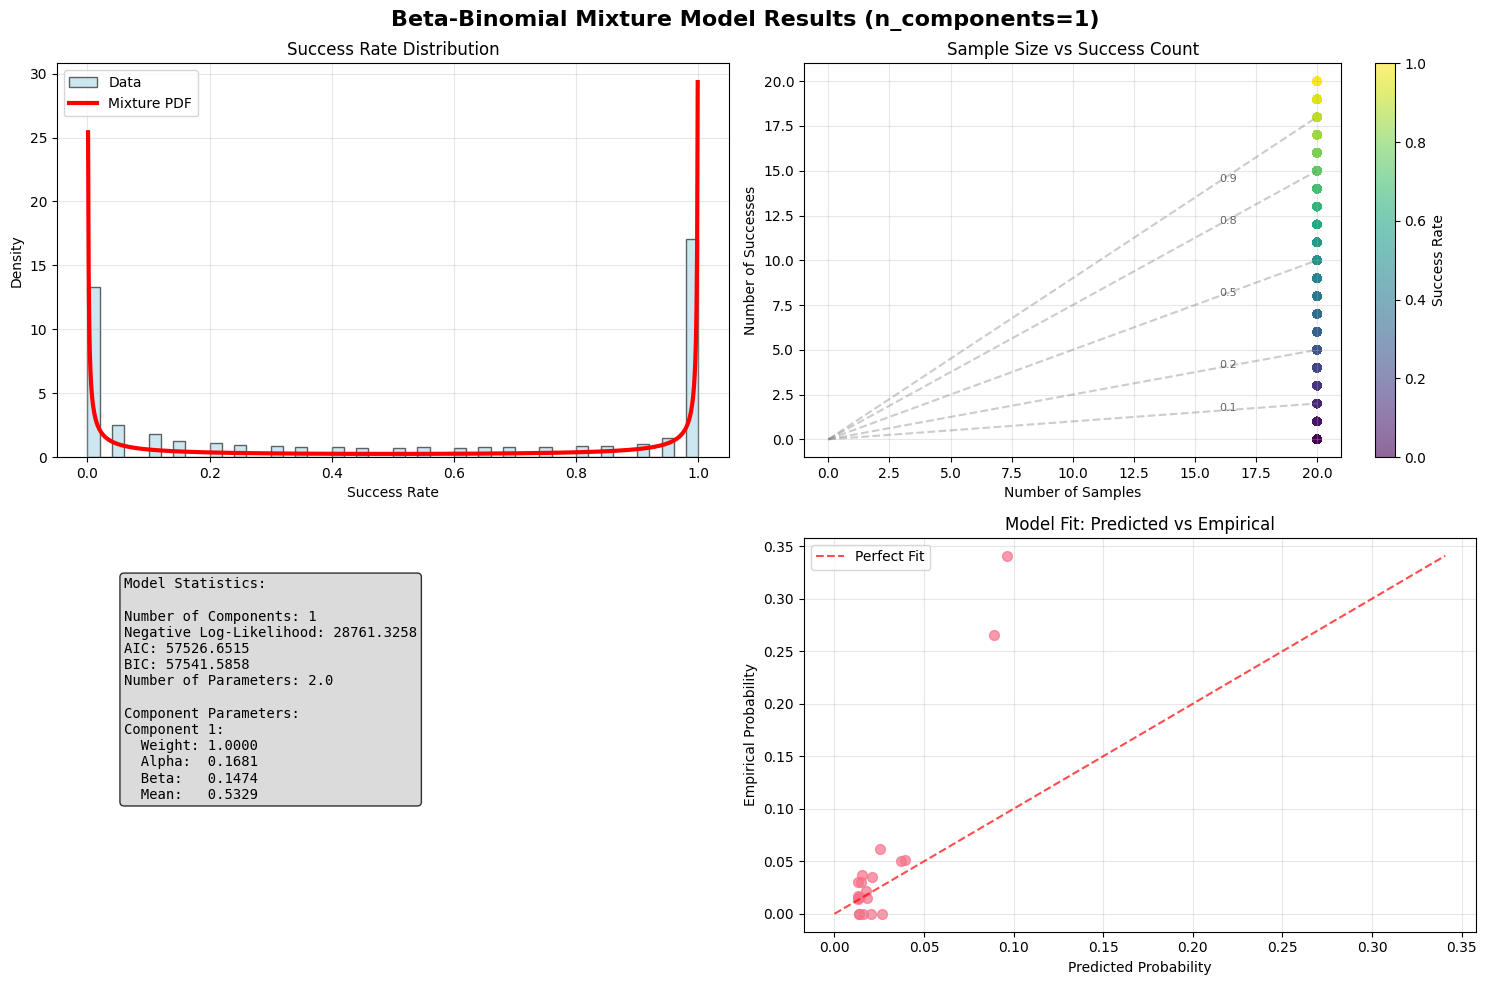

In [64]:
stats_utils.plot_mixture_results(smaller_pythia12_math, beta_mixture_params)

In [67]:
beta_mixture_discrete_pass_at_10000 = 1 - np.exp(
    -1
    * stats_utils.compute_beta_binomial_mixture_negative_log_likelihood(
        params=beta_mixture_params,
        n_components=1,
        num_samples=np.array([10000]),
        num_successes=np.array([0]),
    )
)
beta_mixture_discrete_pass_at_10000

/Users/jkazdan/Documents/Research/monkeys/KoyejoLab-Origin-Power-Laws-Scaling-Inference-Compute/src/stats_utils.py:85: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  a=alphas[i],
/Users/jkazdan/Documents/Research/monkeys/KoyejoLab-Origin-Power-Laws-Scaling-Inference-Compute/src/stats_utils.py:86: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  b=betas[i]


0.25798911173982886

In [91]:
import importlib

importlib.reload(stats_utils)

<module 'src.stats_utils' from '/Users/jkazdan/Documents/Research/monkeys/KoyejoLab-Origin-Power-Laws-Scaling-Inference-Compute/src/stats_utils.py'>